In [1]:
# importing libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [2]:
import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect('C:/Users/kanak/Desktop/Semester 4/culminating-project-group-2/Database/team2_DB.db')  # Replace with your database file
#C:\Users\kanak\Desktop\Semester 4\culminating-project-group-2\Database\team2_DB.db
# Step 1: Retrieve all table names in the database
query_tables = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(query_tables, conn)

# Print table names
print("Tables in the database:")
tables.head(15)
#print(tables['name'].tolist())  # Convert DataFrame column to a list


Tables in the database:


,name
0,sqlite_sequence
1,Year_Table
2,Country_Year
3,Country_Indicators
4,Economic_Indicators
5,Environmental_Indicators
6,Public_Debt_Indicators_Agg
7,Social_Indicators
8,Statistical_Indicators
9,Country


In [5]:
query_tables = "SELECT name FROM sqlite_master WHERE type='table';"
query=  pd.read_sql_query(query_tables, conn)
query = pd.DataFrame(query)
query
#tables = pd.read_sql_query(query_tables, conn)
#SELECT name FROM sqlite_master WHERE type='table';


,name
0,sqlite_sequence
1,Year_Table
2,Country_Year
3,Country_Indicators
4,Economic_Indicators
5,Environmental_Indicators
6,Public_Debt_Indicators_Agg
7,Social_Indicators
8,Statistical_Indicators
9,Country


In [186]:


# Define file names and corresponding variable names
files = {
    "countryIndi": "Country_Indicators.csv",
    "country": "Country.csv",
    "economicIndi": "Economic_Indicators.csv",
    "enviroIndi": "Environmental_Indicators.csv",
    "qpsdIndi": "Public_Debt_Indicators_Agg.csv",
    "socialIndi": "Social_Indicators.csv",
    "statIndi": "Statistical_Indicators.csv",
    "yearIndi": "Year_Table.csv"
}

# Base path
base_path = '../WEEK 3/Indicators/'

# Read all files into a dictionary of DataFrames
data = {key: pd.read_csv(base_path + filename) for key, filename in files.items()}

# Access individual DataFrames like:
# data['countryIndi'], data['economicIndi'], etc.



In [187]:
data.keys()

dict_keys(['countryIndi', 'country', 'economicIndi', 'enviroIndi', 'qpsdIndi', 'socialIndi', 'statIndi', 'yearIndi'])

In [192]:
data['country'].head(3)

,Country Name,Country Code,Unnamed: 2,Unnamed: 3
0,Afghanistan,AFG,NaN,NaN
1,Albania,ALB,NaN,NaN
2,Algeria,DZA,NaN,NaN


In [193]:
data['country'].drop(columns=['Unnamed: 2', 'Unnamed: 3'], inplace=True)

In [194]:
# Fetch column shape from each DataFrame in the dictionary
for name, df in data.items():
    #print(name)
    #print(df)
    print(f"\nShape of '{name}': {df.shape[0]} rows, {df.shape[1]} columns")
    #print(df.shape.tolist())


Shape of 'countryIndi': 809 rows, 10 columns

Shape of 'country': 809 rows, 2 columns

Shape of 'economicIndi': 803 rows, 68 columns

Shape of 'enviroIndi': 803 rows, 11 columns

Shape of 'qpsdIndi': 318 rows, 67 columns

Shape of 'socialIndi': 803 rows, 75 columns

Shape of 'statIndi': 798 rows, 13 columns

Shape of 'yearIndi': 3 rows, 2 columns


In [198]:
# Fetch column shape from each DataFrame in the dictionary
for name, df in data.items():
    #print(name)
    #print(df)
    print(f"\Data Info of '{name}': {df.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 10 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   Country Name                                                                      798 non-null    object 
 1   Country Code                                                                      798 non-null    object 
 2   Time                                                                              798 non-null    float64
 3   Time Code                                                                         798 non-null    object 
 4   Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG]                798 non-null    object 
 5   Adjusted net national income (constant 2015 US$) [NY.ADJ.NNTY.KD]                 798 non-null    object 
 6   Ad

In [195]:
# Fetch column names from each DataFrame in the dictionary
for name, df in data.items():
    print(f"\nColumns in '{name}':")
    print(df.columns.tolist())


Columns in 'countryIndi':
['Country Name', 'Country Code', 'Time', 'Time Code', 'Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG]', 'Adjusted net national income (constant 2015 US$) [NY.ADJ.NNTY.KD]', 'Adjusted net national income (current US$) [NY.ADJ.NNTY.CD]', 'Adjusted net national income per capita (annual % growth) [NY.ADJ.NNTY.PC.KD.ZG]', 'Adjusted net national income per capita (constant 2015 US$) [NY.ADJ.NNTY.PC.KD]', 'Adjusted net national income per capita (current US$) [NY.ADJ.NNTY.PC.CD]']

Columns in 'country':
['Country Name', 'Country Code']

Columns in 'economicIndi':
['Country Name', 'Country Code', 'Time', 'Time Code', 'Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG]', 'Adjusted net national income (constant 2015 US$) [NY.ADJ.NNTY.KD]', 'Adjusted net national income (current US$) [NY.ADJ.NNTY.CD]', 'Current account balance (% of GDP) [BN.CAB.XOKA.GD.ZS]', 'Current account balance (BoP, current US$) [BN.CAB.XOKA.CD]', 'Exports of 

In [196]:
# Merge all on common keys: 'Country Name', 'Country Code', 'Time', 'Time Code'
from functools import reduce

merge_keys = ['Country Name', 'Country Code', 'Time', 'Time Code']

# Exclude 'country' and 'yearIndi' as they are supplementary
dfs_to_merge = [df for key, df in data.items() if key not in ['country', 'yearIndi']]

# Perform successive merges
merged_df = reduce(lambda left, right: pd.merge(left, right, on=merge_keys, how='outer', suffixes=('', '_dup')), dfs_to_merge)

# Drop duplicate columns that were created due to same column names
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]

# Optional: merge 'country' and 'yearIndi' if you need metadata
# merged_df = pd.merge(merged_df, data['country'], on=['Country Name', 'Country Code'], how='left')
# merged_df = pd.merge(merged_df, data['yearIndi'], on=['Time'], how='left')

# Final check
print(f"Merged DataFrame shape: {merged_df.shape}")
print(merged_df.columns[:10])  # Show first few columns


ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

In [32]:
import pandas as pd

# Define only the files you've uploaded
# Read in the events data
file_paths = {
"countryIndi" :'../WEEK 3/Indicators/Country_Indicators.csv',
#
"economicIndi" : '../WEEK 3/Indicators/Economic_Indicators.csv',
"enviroIndi": '../WEEK 3/Indicators/Environmental_Indicators.csv',
"qpsdIndi" : '../WEEK 3/Indicators/Public_Debt_Indicators_Agg.csv',
#"socialIndi" : '../WEEK 3/Indicators/Social_Indicators.csv',
"statIndi" : '../WEEK 3/Indicators/Statistical_Indicators.csv',
#"yearIndi" : '../WEEK 3/Indicators/Year_Table.csv'
}

# Define only the columns relevant for merging and analysis
column_mapping = {
    "countryIndi": [
        'Country Name', 'Country Code', 'Time',
        'Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG]',
        'Adjusted net national income per capita (annual % growth) [NY.ADJ.NNTY.PC.KD.ZG]'
    ],
    "economicIndi": [
        'Country Name', 'Country Code', 'Time',
        'GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]',
        'GDP per capita growth (annual %) [NY.GDP.PCAP.KD.ZG]',
        'GDP per capita (current US$) [NY.GDP.PCAP.CD]',
        'GDP per capita (constant 2015 US$) [NY.GDP.PCAP.KD]',
        'Gross fixed capital formation (% of GDP) [NE.GDI.FTOT.ZS]',
        'Current account balance (% of GDP) [BN.CAB.XOKA.GD.ZS]',
        'Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS]',
        'Imports of goods and services (% of GDP) [NE.IMP.GNFS.ZS]',
        'General government final consumption expenditure (% of GDP) [NE.CON.GOVT.ZS]',
        'Foreign direct investment, net inflows (% of GDP) [BX.KLT.DINV.WD.GD.ZS]'
    ],
    "enviroIndi": [
        'Country Name', 'Country Code', 'Time',
        'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita) [EN.GHG.CO2.PC.CE.AR5]',
        'Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5]',
        'Forest area (sq. km) [AG.LND.FRST.K2]',
        'Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]',
        'Access to electricity, rural (% of rural population) [EG.ELC.ACCS.RU.ZS]',
        'Access to electricity, urban (% of urban population) [EG.ELC.ACCS.UR.ZS]'
    ],
    "statIndi": [
        'Country Name', 'Country Code', 'Time',
        'Renewable electricity output (% of total electricity) [EG.ELC.RNEW.ZS]',
        'Energy use per capita (kg of oil equivalent) [EG.USE.PCAP.KG.OE]'
    ],
    "qpsdIndi": [
        'Country Name', 'Country Code', 'Time',
        'Gross PSD, Budgetary Central Gov., All maturities, All instruments, Nominal Value, % of GDP [DP.DOD.DECT.CR.BC.Z1]',
        'Multilateral debt service (% of public and publicly guaranteed debt service) [DT.TDS.MLAT.PG.ZS]'
    ]
}

# Read and merge the datasets
merged_df = None
for key in file_paths:
    try:
        df = pd.read_csv(file_paths[key], usecols=lambda x: x in column_mapping[key])
        if merged_df is None:
            merged_df = df
        else:
            merged_df = pd.merge(merged_df, df, on=['Country Name', 'Country Code', 'Time'], how='inner')
    except Exception as e:
        print(f"Error processing {key}: {e}")

# Preview merged data
merged_df.head()


,Country Name,Country Code,Time,Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG],Adjusted net national income per capita (annual % growth) [NY.ADJ.NNTY.PC.KD.ZG],Current account balance (% of GDP) [BN.CAB.XOKA.GD.ZS],Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS],"Foreign direct investment, net inflows (% of GDP) [BX.KLT.DINV.WD.GD.ZS]",GDP growth (annual %) [NY.GDP.MKTP.KD.ZG],GDP per capita (constant 2015 US$) [NY.GDP.PCAP.KD],...,GDP per capita growth (annual %) [NY.GDP.PCAP.KD.ZG],General government final consumption expenditure (% of GDP) [NE.CON.GOVT.ZS],Imports of goods and services (% of GDP) [NE.IMP.GNFS.ZS],Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5],Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita) [EN.GHG.CO2.PC.CE.AR5],Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS],"Access to electricity, rural (% of rural population) [EG.ELC.ACCS.RU.ZS]","Access to electricity, urban (% of urban population) [EG.ELC.ACCS.UR.ZS]",Forest area (sq. km) [AG.LND.FRST.K2],"Gross PSD, Budgetary Central Gov., All maturities, All instruments, Nominal Value, % of GDP [DP.DOD.DECT.CR.BC.Z1]"
0,Albania,ALB,2021.0,11.05709518,12.09128911,-7.595907592,31.13302001,6.757906713,8.969553392,4858.052015,...,9.984307568,12.83522445,44.45729608,-24.16403311,1.792282583,41.9,100,100,7889,0.0
1,Albania,ALB,2022.0,..,..,-5.872436401,37.19708481,7.579342194,4.826688314,5154.827498,...,6.108939995,12.04117257,47.50097911,-30.63957863,1.659293031,..,100,100,7889,0.0
2,Albania,ALB,2023.0,..,..,-1.196321748,38.66508179,6.883977454,3.936625257,5419.637791,...,5.137132015,12.04646979,43.82860281,-30.89841986,1.672194764,..,..,..,..,0.0
3,Argentina,ARG,2021.0,12.48955577,12.19086647,1.361544222,18.06670917,1.368380832,10.44181199,12549.28117,...,10.14855999,15.91581794,15.0119804,90.30498784,4.20773344,9.2,100,100,284636.667,0.0
4,Argentina,ARG,2022.0,..,..,-0.640820188,16.24801444,2.402155349,5.269879674,13182.7934,...,5.048195323,15.83565718,15.29969356,93.11930818,4.26096743,..,100,100,283552.222,0.0


In [33]:
merged_df.isna().sum()

Country Name                                                                                                          0
Country Code                                                                                                          0
Time                                                                                                                  0
Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG]                                                    0
Adjusted net national income per capita (annual % growth) [NY.ADJ.NNTY.PC.KD.ZG]                                      0
Current account balance (% of GDP) [BN.CAB.XOKA.GD.ZS]                                                                0
Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS]                                                             0
Foreign direct investment, net inflows (% of GDP) [BX.KLT.DINV.WD.GD.ZS]                                              0
GDP growth (annual %) [NY.GDP.MKTP.KD.ZG

In [34]:
merged_df['Country Name'].nunique()

106

In [35]:
merged_df.shape

(318, 21)

In [36]:
merged_df.isna().sum()

Country Name                                                                                                          0
Country Code                                                                                                          0
Time                                                                                                                  0
Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG]                                                    0
Adjusted net national income per capita (annual % growth) [NY.ADJ.NNTY.PC.KD.ZG]                                      0
Current account balance (% of GDP) [BN.CAB.XOKA.GD.ZS]                                                                0
Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS]                                                             0
Foreign direct investment, net inflows (% of GDP) [BX.KLT.DINV.WD.GD.ZS]                                              0
GDP growth (annual %) [NY.GDP.MKTP.KD.ZG

In [41]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318 entries, 0 to 317
Data columns (total 21 columns):
 #   Column                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                              --------------  -----  
 0   Country Name                                                                                                        318 non-null    object 
 1   Country Code                                                                                                        318 non-null    object 
 2   Time                                                                                                                318 non-null    float64
 3   Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG]                                                  318 non-null    object 
 4   Adjusted net nationa

#####
Can we classify countries based on whether rapid economic growth leads to higher environmental degradation? (High/Moderate/Low Impact) 

In [141]:
# Subset of essential columns
cols_needed = [
    'Country Name',
    'GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]',
    'Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5]',
    'Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]'
]

# Drop rows with missing values in key columns
df_filtered = merged_df.dropna(subset=cols_needed)
print(f"Usable rows for classification: {df_filtered.shape[0]}")


Usable rows for classification: 318


In [142]:
# List of columns to exclude
exclude_cols = ['Country Name', 'Country Code', 'Time']

# Loop through all other columns and convert to numeric
for col in df_filtered.columns:
    if col not in exclude_cols:
        df_filtered[col] = pd.to_numeric(df_filtered[col], errors='coerce')


In [143]:
df_filtered['Time'] = df_filtered['Time'].astype('Int64')  # Nullable integer type


In [144]:
print(df_filtered.shape)
# checking for null values
missing_values_count = df_filtered.isnull().sum()
missing_values_count

(318, 21)


Country Name                                                                                                            0
Country Code                                                                                                            0
Time                                                                                                                    0
Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG]                                                    226
Adjusted net national income per capita (annual % growth) [NY.ADJ.NNTY.PC.KD.ZG]                                      226
Current account balance (% of GDP) [BN.CAB.XOKA.GD.ZS]                                                                 13
Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS]                                                              23
Foreign direct investment, net inflows (% of GDP) [BX.KLT.DINV.WD.GD.ZS]                                                2
GDP growth (annual %) [N

c:\Users\kanak\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


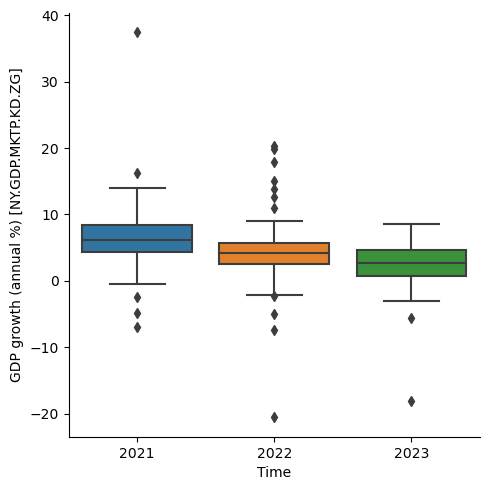

In [139]:
#create the box plot
sns.catplot(data= df_filtered, x='Time',
            y='GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]',kind='box')

c:\Users\kanak\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


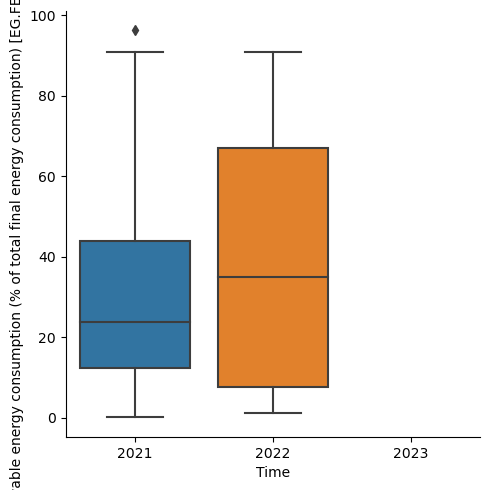

In [140]:
#create the box plot
sns.catplot(data= df_filtered, x='Time',
            y='Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]',kind='box')

In [101]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318 entries, 0 to 317
Data columns (total 21 columns):
 #   Column                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                              --------------  -----  
 0   Country Name                                                                                                        318 non-null    object 
 1   Country Code                                                                                                        318 non-null    object 
 2   Time                                                                                                                318 non-null    Int64  
 3   Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG]                                                  92 non-null     float64
 4   Adjusted net nationa

In [102]:
# let try using cluster analysis 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Step 1: Select relevant columns
features = df_filtered[[
    'GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]',
    'Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5]',
    'Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]'
]].dropna()  # Drop rows with missing data

# Step 2: Scale the features (important for KMeans)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


# Step 3: Run KMeans with 3 clusters (High, Moderate, Low Impact)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Step 4: Add cluster labels back to the original dataframe
features['Impact_Cluster'] = clusters


# Step 5: Interpret and label clusters
# You might want to look at group means to rename clusters meaningfully
cluster_means = features.groupby('Impact_Cluster').mean()
cluster_means

cluster_map = {
    0: 'High Impact',
    1: 'Moderate Impact',
    2: 'Low Impact'
}
features['Impact_Label'] = features['Impact_Cluster'].map(cluster_map)





c:\Users\kanak\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


####
analyze country-level insights from your clustered data.

In [103]:
# Merge Impact_Label from clustering back to main df
df_clustered = df_filtered.merge(
    features[['Impact_Label']],
    left_index=True,
    right_index=True,
    how='left'
)

# Show example countries from each cluster
df_clustered[['Country Name', 'Time', 'Impact_Label']].drop_duplicates().groupby('Impact_Label').head(5)

df_clustered.groupby('Impact_Label')[[
    'GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]',
    'Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5]',
    'Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]'
]].mean().round(2)


,GDP growth (annual %) [NY.GDP.MKTP.KD.ZG],Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5],Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]
Impact_Label,,,
High Impact,13.77,1885.41,17.77
Low Impact,5.17,459.50,65.10
Moderate Impact,4.25,803.12,17.96


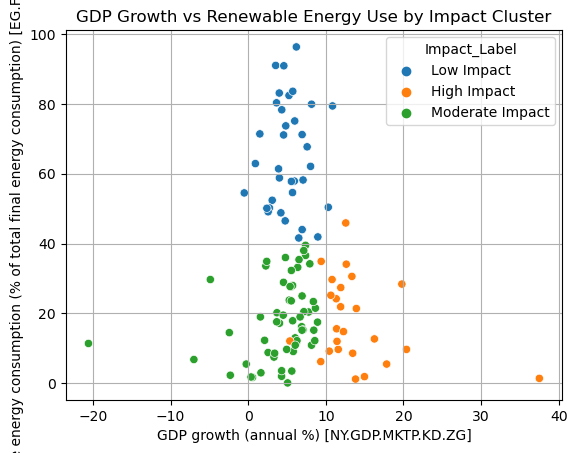

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    data=df_clustered,
    x='GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]',
    y='Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]',
    hue='Impact_Label'
)
plt.title("GDP Growth vs Renewable Energy Use by Impact Cluster")
plt.grid(True)
plt.show()


In [109]:
df_clustered.head(8)

,Country Name,Country Code,Time,Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG],Adjusted net national income per capita (annual % growth) [NY.ADJ.NNTY.PC.KD.ZG],Current account balance (% of GDP) [BN.CAB.XOKA.GD.ZS],Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS],"Foreign direct investment, net inflows (% of GDP) [BX.KLT.DINV.WD.GD.ZS]",GDP growth (annual %) [NY.GDP.MKTP.KD.ZG],GDP per capita (constant 2015 US$) [NY.GDP.PCAP.KD],...,General government final consumption expenditure (% of GDP) [NE.CON.GOVT.ZS],Imports of goods and services (% of GDP) [NE.IMP.GNFS.ZS],Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5],Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita) [EN.GHG.CO2.PC.CE.AR5],Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS],"Access to electricity, rural (% of rural population) [EG.ELC.ACCS.RU.ZS]","Access to electricity, urban (% of urban population) [EG.ELC.ACCS.UR.ZS]",Forest area (sq. km) [AG.LND.FRST.K2],"Gross PSD, Budgetary Central Gov., All maturities, All instruments, Nominal Value, % of GDP [DP.DOD.DECT.CR.BC.Z1]",Impact_Label
0,Albania,ALB,2021,11.057095,12.091289,-7.595908,31.133020,6.757907,8.969553,4858.052015,...,12.835224,44.457296,-24.164033,1.792283,41.9,100.0,100.0,7889.000,0.0,Low Impact
1,Albania,ALB,2022,NaN,NaN,-5.872436,37.197085,7.579342,4.826688,5154.827498,...,12.041173,47.500979,-30.639579,1.659293,NaN,100.0,100.0,7889.000,0.0,NaN
2,Albania,ALB,2023,NaN,NaN,-1.196322,38.665082,6.883977,3.936625,5419.637791,...,12.046470,43.828603,-30.898420,1.672195,NaN,NaN,NaN,NaN,0.0,NaN
3,Argentina,ARG,2021,12.489556,12.190866,1.361544,18.066709,1.368381,10.441812,12549.281170,...,15.915818,15.011980,90.304988,4.207733,9.2,100.0,100.0,284636.667,0.0,High Impact
4,Argentina,ARG,2022,NaN,NaN,-0.640820,16.248014,2.402155,5.269880,13182.793400,...,15.835657,15.299694,93.119308,4.260967,NaN,100.0,100.0,283552.222,0.0,NaN
5,Argentina,ARG,2023,NaN,NaN,-3.243513,12.749246,3.694019,-1.611002,12933.249730,...,16.387469,13.891266,83.434277,4.035680,NaN,NaN,NaN,NaN,0.0,NaN
6,Armenia,ARM,2021,2.402778,2.375123,-3.479974,35.906440,2.640303,5.800000,4264.799615,...,13.649850,43.763449,-63.863504,2.534922,9.1,100.0,99.9,3282.600,0.0,Moderate Impact
7,Armenia,ARM,2022,NaN,NaN,0.331693,50.224980,4.999916,12.600000,4791.004817,...,11.676482,51.185798,-64.921728,2.454971,NaN,100.0,100.0,3280.500,0.0,NaN


###
🔹 Q1: Are high-growth countries investing in renewables or ignoring them?
Answer:
High-growth countries (clustered in the High Impact group) are largely ignoring renewables.
Despite strong GDP growth (often >10%), these countries show low renewable energy adoption, typically below 20%.
This suggests a growth model still dependent on fossil fuels, contributing to environmental degradation.

🔹 Q2: Do low-impact countries have higher renewable energy adoption?
Answer:
Yes, significantly.
Low-impact countries (shown in blue) exhibit very high renewable energy use — often above 60% — and moderate or low GDP growth.
These countries are likely balancing economic activity with strong environmental policies and clean energy investments, leading to their low impact classification.

🔹 Q3: Is moderate impact a transition zone?
Answer:
Yes — the Moderate Impact cluster appears to represent a transitional group.
These countries have moderate renewable energy use (10–40%) and low to mid GDP growth.
They might be in the process of increasing clean energy usage or adjusting their growth models, moving either toward sustainability or unsustainability depending on their future trajectory.



#####
LETS TRY TO ANS FIRST : Classify countries into "Investing" or "Ignoring" renewables using GDP growth as the input.

In [118]:
#Step 1: Create a Label — “Renewable_Label”
# Label countries as Investing vs Ignoring based on renewable energy threshold (30% is a common mark)
df_clustered['Renewable_Label'] = df_clustered[
    'Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]'
].apply(lambda x: 'Investing' if x >= 30 else 'Ignoring')

In [119]:
# Step 2: Prepare the Features and Labels
from sklearn.model_selection import train_test_split

# Select features and labels
X = df_clustered[['GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]']].dropna()
y = df_clustered.loc[X.index, 'Renewable_Label']


In [122]:
#Assumption 1 If the model accurately predicts "Investing" based on GDP, 
# then GDP growth influences renewable adoption.

#Assumption 2 : If most high-GDP-growth countries are predicted as "Ignoring", 
# it confirms that economic growth does not align with renewable investment.

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Train model
#clf = DecisionTreeClassifier(max_depth=3, random_state=42,class_weight='balanced')
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    Ignoring       0.86      0.97      0.91        67
   Investing       0.33      0.08      0.13        12

    accuracy                           0.84        79
   macro avg       0.59      0.53      0.52        79
weighted avg       0.78      0.84      0.79        79



Assumption 1:
If the model accurately predicts "Investing" based on GDP, then GDP growth influences renewable adoption.

✔️ Tree confirms this:
The tree only uses GDP growth to make predictions.

If it's able to split and correctly separate Investing vs Ignoring, then GDP growth must be informative.

🧠 Example from the tree:

If GDP growth < 1.11, many samples are predicted as "Ignoring".

If GDP growth > 4.62, there are leaves for both Investing and Ignoring, which means GDP alone isn't always decisive — but it's helping guide the prediction.

📌 Conclusion:
✅ Yes, the model shows that GDP growth influences, but doesn’t fully determine renewable adoption.

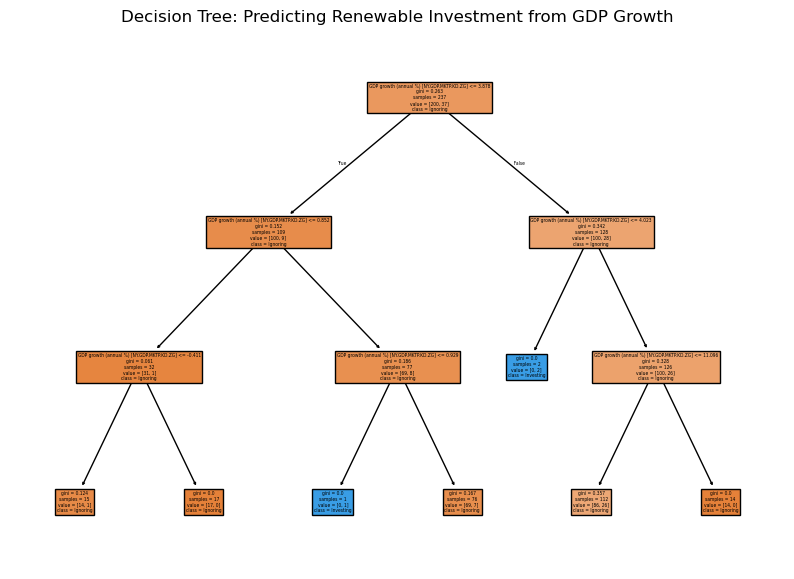

In [123]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plot_tree(clf, feature_names=X.columns, class_names=clf.classes_, filled=True)
plt.title("Decision Tree: Predicting Renewable Investment from GDP Growth")
plt.show()


In [145]:
# Is economic growth a predictor of a country’s renewable energy adoption rate? 
#Predict whether a country is a "High" or "Low" renewable energy adopter using economic growth indicators.
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Assuming you've already merged data across files based on Country, Year, etc.
# df_merged = your merged DataFrame

# Step 1: Select relevant columns
df_model = df_filtered[[
    'GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]',
    'GDP per capita growth (annual %) [NY.GDP.PCAP.KD.ZG]',
    'Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG]',
    'Gross domestic savings (% of GDP) [NY.GDS.TOTL.ZS]',
    'General government final consumption expenditure (% of GDP) [NE.CON.GOVT.ZS]',
    'Foreign direct investment, net inflows (% of GDP) [BX.KLT.DINV.WD.GD.ZS]',
    'Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]'
]].copy()

# Step 2: Drop missing values
df_model.dropna(inplace=True)

# Step 3: Create classification target (High vs Low adopter)
# Threshold: 30% renewable energy use
df_model['Renewable_Adopter'] = df_model[
    'Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]'
].apply(lambda x: 'High' if x >= 30 else 'Low')

# Step 4: Split features and labels
X = df_model.drop(columns=['Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]', 'Renewable_Adopter'])
y = df_model['Renewable_Adopter']

# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Step 6: Train Random Forest
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Step 7: Evaluate model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


KeyError: "['Gross domestic savings (% of GDP) [NY.GDS.TOTL.ZS]'] not in index"

###
TRYING THIS WILL DELETE LATER 

In [126]:
# Define function to classify environmental degradation
def classify_environmental_impact(co2_change, renewable_pct):
    if co2_change > 5 and renewable_pct < 10:
        return 'High Impact'
    elif co2_change > 0 and renewable_pct < 20:
        return 'Moderate Impact'
    else:
        return 'Low Impact'

# Apply classification
df_filtered['Env_Impact_Label'] = df_filtered.apply(
    lambda x: classify_environmental_impact(
        x['Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.CO2.ZG.AR5]'],
        x['Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]']
    ), axis=1)

#categorize economic growth
def classify_growth(gdp_growth):
    if gdp_growth > 5:
        return 'High Growth'
    elif gdp_growth >= 2:
        return 'Moderate Growth'
    else:
        return 'Low Growth'

df_filtered['Growth_Label'] = df_filtered['GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]'].apply(classify_growth)


In [127]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

#Step 1: Create a Label — “Renewable_Label”
# Label countries as Investing vs Ignoring based on renewable energy threshold (30% is a common mark)
df_filtered['Renewable_Label'] = df_filtered[
    'Renewable energy consumption (% of total final energy consumption) [EG.FEC.RNEW.ZS]'
].apply(lambda x: 'Investing' if x >= 30 else 'Ignoring')

# Step 2: Prepare the Features and Labels
# Select features and labels
X = df_filtered[['GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]']].dropna()
y = df_filtered.loc[X.index, 'Renewable_Label']


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Train model
#clf = DecisionTreeClassifier(max_depth=3, random_state=42,class_weight='balanced')
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    Ignoring       0.86      0.97      0.91        67
   Investing       0.33      0.08      0.13        12

    accuracy                           0.84        79
   macro avg       0.59      0.53      0.52        79
weighted avg       0.78      0.84      0.79        79

